In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.applications import ResNetRS50
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import random
import sys
import os

import warnings
warnings.filterwarnings("ignore")

In [7]:
ROOT_dir = "./2750/"

In [8]:
folders = os.listdir(ROOT_dir)

In [9]:
len_of_images = []
for i in folders:
    file_path = os.listdir("{}/{}".format(ROOT_dir,i))
    len_of_images.append(len(file_path))
    print(f"{i}:{len(file_path)} files")

Highway:2500 files
HerbaceousVegetation:3000 files
Forest:3000 files
PermanentCrop:2500 files
River:2500 files
Pasture:2000 files
Industrial:2500 files
SeaLake:3000 files
AnnualCrop:3000 files
Residential:3000 files


In [10]:
sum(len_of_images)

27000

In [11]:
file_path = os.listdir("{}/{}".format(ROOT_dir,"Highway"))

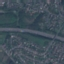

In [12]:
Image.open(ROOT_dir+"Highway/"+file_path[90])

In [13]:
Image.open(ROOT_dir+"Highway/"+file_path[90]).size

(64, 64)

Text(0, 0.5, 'Total Images')

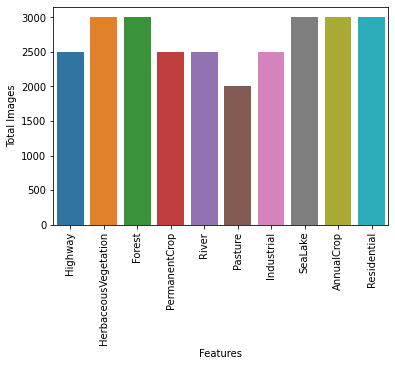

In [14]:
sns.barplot(folders,len_of_images)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Total Images")

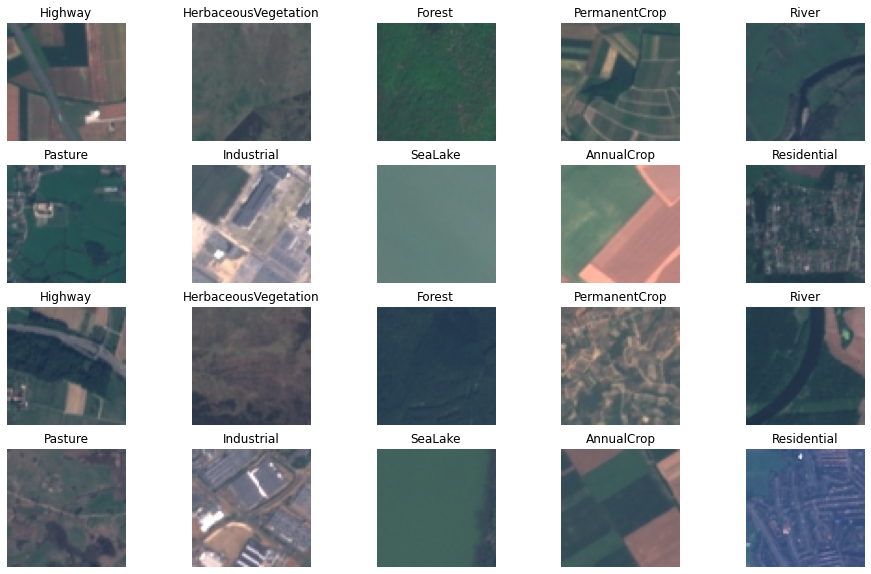

In [15]:
plt.figure(figsize=(16,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    file_path = os.listdir("{}/{}".format(ROOT_dir,folders[i%10]))
    image_ = Image.open(ROOT_dir+folders[i%10]+"/"+file_path[random.randint(1,1500)])
    plt.imshow(image_)
    plt.title(folders[i%10])
    plt.axis("off")

### Use Keras preprocessing layers

In [16]:
TRAIN_DIR = './training'
TEST_DIR = './testing'
BATCH_SIZE = 64
NUM_CLASSES=len(folders)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

In [17]:
for path in [TRAIN_DIR,TEST_DIR]:
    if not os.path.exists(path):
        os.mkdir(path)

In [20]:
for subfolder in folders:
    if not os.path.exists(os.path.join(TRAIN_DIR,subfolder)):
        os.mkdir(os.path.join(TRAIN_DIR,subfolder))

    if not os.path.exists(os.path.join(TEST_DIR, subfolder)):
        os.mkdir(os.path.join(TEST_DIR, subfolder))

In [21]:
dataset = {}
for value_class in folders:
    for img in os.listdir(ROOT_dir+'/'+value_class):
        dataset.update({os.path.join(ROOT_dir,value_class,img):value_class})

In [22]:
len(dataset)

27000

In [23]:
sum(len_of_images)

27000

In [27]:
X = pd.Series(dataset.keys())
y = pd.get_dummies(dataset.values())

In [30]:
y

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
26995,0,0,0,0,0,0,0,1,0,0
26996,0,0,0,0,0,0,0,1,0,0
26997,0,0,0,0,0,0,0,1,0,0
26998,0,0,0,0,0,0,0,1,0,0


In [33]:
split = ShuffleSplit(n_splits=1,test_size=0.25,train_size=0.75,random_state=42)

In [38]:
for tra,tes in split.split(X,y):
    print(tra)
    print(tes)
    print(len(tra))
    print(len(tes))
    break

[ 6517 16397 16266 ...   860 15795 23654]
[ 5312 18357  6428 ... 18258 23066 12176]
20250
6750


In [40]:
27000*0.75 #training dataset set

20250.0

In [47]:
import re
import shutil
from tqdm import tqdm

for train_idx, test_idx in split.split(X, y):
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('./2750', './training', i) for i in train_paths]
    new_test_paths = [re.sub('./2750/', './testing/', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|█████████████████████████████████| 20250/20250 [00:00<00:00, 530000.22it/s]


moving testing files..


100%|███████████████████████████████████████| 6750/6750 [05:13<00:00, 21.54it/s]


In [105]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.1,
  subset="training",
  seed=42,
  image_size=(64, 64),
  batch_size=BATCH_SIZE)

Found 20250 files belonging to 10 classes.
Using 18225 files for training.


In [106]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=42,
  image_size=(64, 64),
  batch_size=BATCH_SIZE)

Found 6750 files belonging to 10 classes.


In [107]:
class_names = train_ds.class_names

In [108]:
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

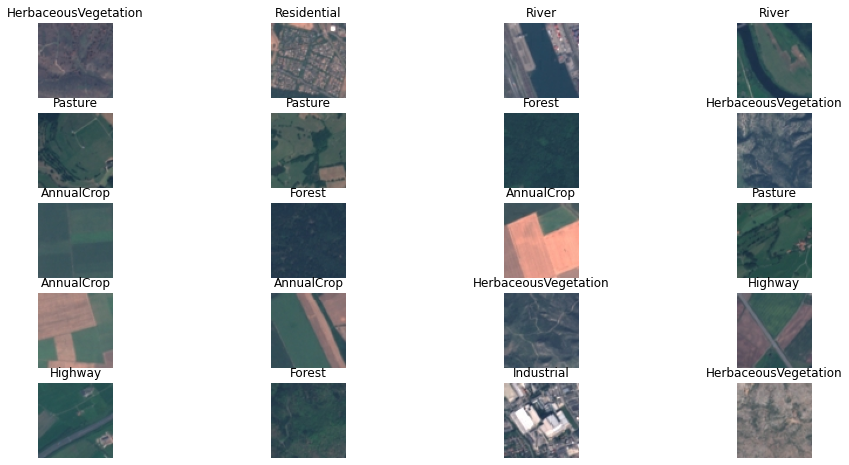

In [109]:
plt.figure(figsize=(16,8))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [110]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [111]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10,activation="softmax")
])

In [112]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [114]:
history = model.fit(train_ds,validation_data=test_ds,epochs=10)

Epoch 1/10
285/285 [==============================] - 21s 74ms/step - loss: 1.1475 - accuracy: 0.5696 - val_loss: 0.9403 - val_accuracy: 0.6656
Epoch 2/10
285/285 [==============================] - 16s 56ms/step - loss: 0.9780 - accuracy: 0.6396 - val_loss: 0.8381 - val_accuracy: 0.6975
Epoch 3/10
285/285 [==============================] - 16s 58ms/step - loss: 0.8952 - accuracy: 0.6742 - val_loss: 0.7906 - val_accuracy: 0.7135
Epoch 4/10
285/285 [==============================] - 18s 62ms/step - loss: 0.8501 - accuracy: 0.6910 - val_loss: 0.7739 - val_accuracy: 0.7201
Epoch 5/10
285/285 [==============================] - 17s 61ms/step - loss: 0.8238 - accuracy: 0.6955 - val_loss: 0.7600 - val_accuracy: 0.7234
Epoch 6/10
285/285 [==============================] - 17s 61ms/step - loss: 0.8066 - accuracy: 0.7032 - val_loss: 0.7256 - val_accuracy: 0.7342
Epoch 7/10
285/285 [==============================] - 18s 64ms/step - loss: 0.7757 - accuracy: 0.7124 - val_loss: 0.7013 - val_accuracy:

In [116]:
model.evaluate(test_ds)

106/106 [==============================] - 2s 18ms/step - loss: 0.7043 - accuracy: 0.7424


[0.7042968273162842, 0.7423703670501709]

In [117]:
model.evaluate(train_ds)

285/285 [==============================] - 5s 18ms/step - loss: 0.6759 - accuracy: 0.7476


[0.6759486198425293, 0.7475994229316711]

Our model is neither underfitting or overfitting, some tuning is required

In [119]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 16)       